In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import sparse
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE
import joblib


 2. Preprocessing Setup

In [20]:
modeling_df  = pd.read_csv('../models/final_balanced_train.csv')

print("Loaded modeling_df shape:", modeling_df.shape)
modeling_df.head()


Loaded modeling_df shape: (17880, 41)


,title,location,department,salary_range,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,...,employment_type_is_missing,required_experience_is_missing,required_education_is_missing,industry_is_missing,function_is_missing,salary_min_is_missing,salary_max_is_missing,salary_avg_is_missing,title_suspicious_count,company_info_score
0,Marketing Intern,"US, NY, New York",Marketing,NaN,0,1,0,Other,Internship,NaN,...,0,0,1,1,0,1,1,1,0,2
1,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,0,1,0,Full-time,Not Applicable,NaN,...,0,0,1,0,0,1,1,1,0,2
2,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,0,1,0,NaN,NaN,NaN,...,1,1,1,1,1,1,1,1,0,2
3,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,...,0,0,0,0,0,1,1,1,0,2
4,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,...,0,0,0,0,0,1,1,1,0,2


In [21]:
# Split into features and target
X = modeling_df .drop('fraudulent', axis=1)
y = modeling_df ['fraudulent']

In [22]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(y_train.value_counts())


fraudulent
0    13611
1      693
Name: count, dtype: int64


In [23]:
# Define features and target
X = modeling_df.drop('fraudulent', axis=1)
y = modeling_df['fraudulent']

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set: {X_train.shape}, Test set: {X_test.shape}")

# Identify feature types
categorical_features = [
    col for col in X.columns if X[col].dtype == 'object' and 
    not col.endswith('_cleaned')
]

numerical_features = [
    col for col in X.columns if X[col].dtype != 'object' and 
    not col.endswith('_is_missing')
]

text_features = [col for col in X.columns if col.endswith('_cleaned')]

print(f"Features breakdown:")
print(f"- Categorical: {len(categorical_features)}")
print(f"- Numerical: {len(numerical_features)}")
print(f"- Text: {len(text_features)}")

# Create preprocessing pipeline
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Create the preprocessing pipeline without text features first
transformers = [
    ('cat', categorical_transformer, categorical_features),
    ('num', numerical_transformer, numerical_features)
]

# Create preprocessor
preprocessor = ColumnTransformer(
    transformers=transformers,
    remainder='drop'
)

# Process non-text features first
print("Fitting preprocessing pipeline for non-text features...")
X_train_processed_non_text = preprocessor.fit_transform(X_train)
X_test_processed_non_text = preprocessor.transform(X_test)

# Now handle text features separately with proper dimension handling
print("Processing text features...")

text_features_processed_train = []
text_features_processed_test = []
tfidf_vectorizers = []

for text_feature in text_features:
    vectorizer = TfidfVectorizer(max_features=100)

    # Fill missing values
    X_train[text_feature] = X_train[text_feature].fillna('')
    X_test[text_feature] = X_test[text_feature].fillna('')

    # Fit TF-IDF on training data only
    vectorizer.fit(X_train[text_feature])

    # Transform both train and test
    text_train = vectorizer.transform(X_train[text_feature])
    text_test = vectorizer.transform(X_test[text_feature])

    # Save processed text matrices
    text_features_processed_train.append(text_train)
    text_features_processed_test.append(text_test)

    # Save the vectorizer for export later
    tfidf_vectorizers.append(vectorizer)


# Combine all features
# If there are text features, combine them with non-text features
if text_features:
    all_features_train = sparse.hstack([X_train_processed_non_text] + text_features_processed_train)
    all_features_test = sparse.hstack([X_test_processed_non_text] + text_features_processed_test)
else:
    all_features_train = X_train_processed_non_text
    all_features_test = X_test_processed_non_text

# Convert to CSR format for efficiency
X_train_processed = all_features_train.tocsr()
X_test_processed = all_features_test.tocsr()

print(f"Processed training set shape: {X_train_processed.shape}")
print(f"Processed test set shape: {X_test_processed.shape}")

# Apply SMOTE to handle class imbalance
print("Applying SMOTE to balance training data...")
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_processed, y_train)

print(f"Original training class distribution: {pd.Series(y_train).value_counts().to_dict()}")
print(f"Balanced training class distribution: {pd.Series(y_train_balanced).value_counts().to_dict()}")

Training set: (14304, 40), Test set: (3576, 40)
Features breakdown:
- Categorical: 9
- Numerical: 12
- Text: 4
Fitting preprocessing pipeline for non-text features...
Processing text features...
Processed training set shape: (14304, 14584)
Processed test set shape: (3576, 14584)
Applying SMOTE to balance training data...
Original training class distribution: {0: 13611, 1: 693}
Balanced training class distribution: {0: 13611, 1: 13611}


c:\Users\arpit\anaconda3\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\arpit\anaconda3\Lib\site-packages\sklearn\utils\_tags.py:354: FutureWarning: The SMOTE or classes from which it inherits use `_get_tags` and `_more_tags`. Please define the `__sklearn_tags__` method, or inherit from `sklearn.base.BaseEstimator` and/or other appropriate mixins such as `sklearn.base.TransformerMixin`, `sklearn.base.ClassifierMixin`, `sklearn.base.RegressorMixin`, and `sklearn.base.OutlierMixin`. From scikit-learn 1.7, not defining `__sklearn_tags__` will raise an error.
  warnings.warn(


In [25]:
print(tfidf_vectorizers)  # This will throw an error if not defined yet
print(modeling_df.columns.tolist())

[TfidfVectorizer(max_features=100), TfidfVectorizer(max_features=100), TfidfVectorizer(max_features=100), TfidfVectorizer(max_features=100)]
['title', 'location', 'department', 'salary_range', 'telecommuting', 'has_company_logo', 'has_questions', 'employment_type', 'required_experience', 'required_education', 'industry', 'function', 'fraudulent', 'description_cleaned', 'description_word_count', 'requirements_cleaned', 'requirements_word_count', 'benefits_cleaned', 'benefits_word_count', 'company_profile_cleaned', 'company_profile_word_count', 'salary_min', 'salary_max', 'salary_avg', 'location_is_missing', 'department_is_missing', 'salary_range_is_missing', 'company_profile_is_missing', 'description_is_missing', 'requirements_is_missing', 'benefits_is_missing', 'employment_type_is_missing', 'required_experience_is_missing', 'required_education_is_missing', 'industry_is_missing', 'function_is_missing', 'salary_min_is_missing', 'salary_max_is_missing', 'salary_avg_is_missing', 'title_sus

Training Random Forest classifier...
Best Random Forest parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Best cross-validation F1 score: 0.9983
✅ Model, preprocessors, and vectorizers saved successfully.

Random Forest Test Set Performance:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      3403
           1       0.99      0.67      0.80       173

    accuracy                           0.98      3576
   macro avg       0.99      0.84      0.90      3576
weighted avg       0.98      0.98      0.98      3576



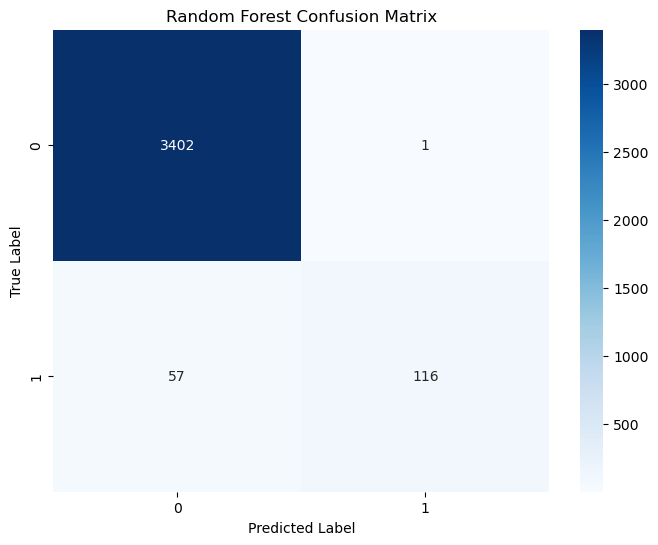

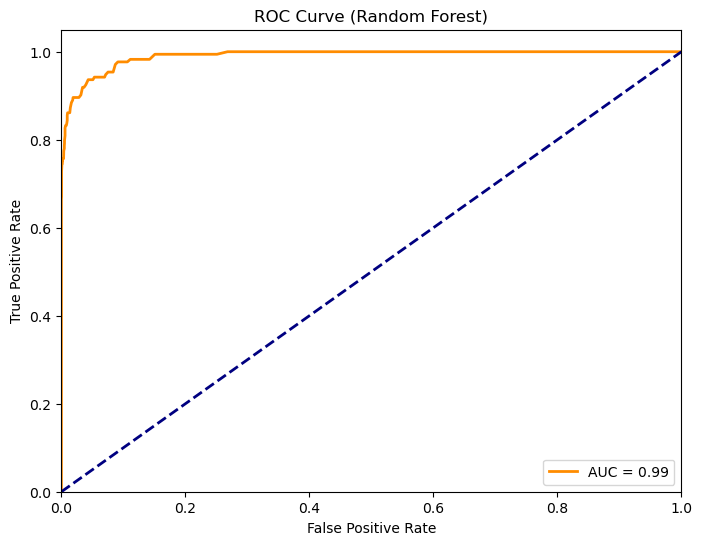

In [28]:
# Train Random Forest classifier
print("Training Random Forest classifier...")
# Define parameter grid
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}
# Create base model
rf = RandomForestClassifier(random_state=42, class_weight='balanced')
# Use GridSearch with cross-validation
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,
    scoring='f1',
    n_jobs=-1
)
# Fit the model
grid_search.fit(X_train_balanced, y_train_balanced)
# Get best model
rf_model = grid_search.best_estimator_
print(f"Best Random Forest parameters: {grid_search.best_params_}")
print(f"Best cross-validation F1 score: {grid_search.best_score_:.4f}")

import joblib

# Save the trained model
joblib.dump(rf_model, '../models/rf_model.pkl')

# Save the structured feature preprocessor
joblib.dump(preprocessor, '../models/rf_preprocessor.pkl')

# ✅ Save each fitted TF-IDF vectorizer
for i, vectorizer in enumerate(tfidf_vectorizers):
    joblib.dump(vectorizer, f'tfidf_{text_features[i]}.pkl')

print("✅ Model, preprocessors, and vectorizers saved successfully.")




# Evaluate on test set
rf_predictions = rf_model.predict(X_test_processed)
rf_probabilities = rf_model.predict_proba(X_test_processed)[:, 1]
print("\nRandom Forest Test Set Performance:")
print(classification_report(y_test, rf_predictions))
# Plot confusion matrix
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, rf_predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Random Forest Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()
# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, rf_probabilities)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve (Random Forest)')
plt.legend(loc="lower right")
plt.show()